<a href="https://colab.research.google.com/github/pachterlab/monod/blob/main/Monod_demo_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Monod* on Colab

In the current notebook, we apply *Monod* to identify differentially regulated genes between GABAergic and glutamatergic cell types in a single Allen dataset.

# Inference pipeline

## Import Prerequisites

In [ ]:
!pip install scanpy
!pip install loompy

## Install Monod

In [ ]:
!git clone https://github.com/pachterlab/monod.git

%cd monod
!pip install -q ./\n
!pip install -q -r /content/monod/src/monod.egg-info/requires.txt
%cd ../

In [ ]:
import sys
import scanpy
sys.path.insert(0, 'monod/src/monod')
import extract_data, cme_toolbox, inference, analysis, mminference

## Import data

In [ ]:
! git clone https://github.com/pachterlab/monod_examples.git
%cd monod_examples
!git checkout anndata
%cd ../

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import anndata
from IPython.display import display, Markdown
import scanpy as sc
import anndata as ad
import numpy as np
import os
import zlib
import math
import argparse
from pathlib import Path

In [3]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore") #warning suppression within script is not respected by colab
warnings.simplefilter('ignore')

Let's make sure that the version is correct.

## Import data

In [4]:
def decompress_chunk(compressed_data):
    """Decompress a zlib-compressed bytes object"""
    return zlib.decompress(compressed_data)

def combine_chunks(input_dir, output_file):
    """Combine compressed chunks back into a single h5ad file"""
    # Get all chunk files sorted by name
    chunk_files = sorted(Path(input_dir).glob('chunk_*.gz'))

    # Combine chunks
    combined_data = bytes()
    for chunk_file in chunk_files:
        with open(chunk_file, 'rb') as f:
            compressed_chunk = f.read()
        chunk = decompress_chunk(compressed_chunk)
        combined_data += chunk
        print(f'Processed chunk: {chunk_file}')

    # Write combined data to temporary file
    with open('temp_combined.h5ad', 'wb') as f:
        f.write(combined_data)

    # Load and save as AnnData to ensure proper format
    adata = ad.read_h5ad('temp_combined.h5ad')
    adata.write(output_file)#, compression='gzip')

    # Clean up temporary file
    os.remove('temp_combined.h5ad')
    print(f'Successfully created combined file: {output_file}')

In [5]:
combine_chunks('monod_examples/sample_data/gaba_anndata', 'gaba_example.h5ad')
combine_chunks('monod_examples/sample_data/glu_anndata', 'glu_example.h5ad')

Processed chunk: monod_examples/sample_data/gaba_anndata/chunk_0000.gz
Processed chunk: monod_examples/sample_data/gaba_anndata/chunk_0001.gz
Successfully created combined file: gaba_example.h5ad
Processed chunk: monod_examples/sample_data/glu_anndata/chunk_0000.gz
Processed chunk: monod_examples/sample_data/glu_anndata/chunk_0001.gz
Processed chunk: monod_examples/sample_data/glu_anndata/chunk_0002.gz
Processed chunk: monod_examples/sample_data/glu_anndata/chunk_0003.gz
Processed chunk: monod_examples/sample_data/glu_anndata/chunk_0004.gz
Processed chunk: monod_examples/sample_data/glu_anndata/chunk_0005.gz
Processed chunk: monod_examples/sample_data/glu_anndata/chunk_0006.gz
Processed chunk: monod_examples/sample_data/glu_anndata/chunk_0007.gz
Processed chunk: monod_examples/sample_data/glu_anndata/chunk_0008.gz
Processed chunk: monod_examples/sample_data/glu_anndata/chunk_0009.gz
Successfully created combined file: glu_example.h5ad


### Load data and filter if desired

In [6]:
glu_adata = anndata.read_h5ad('./glu_example.h5ad')

In [7]:
gaba_adata = anndata.read_h5ad('./gaba_example.h5ad')

Create knee plot.

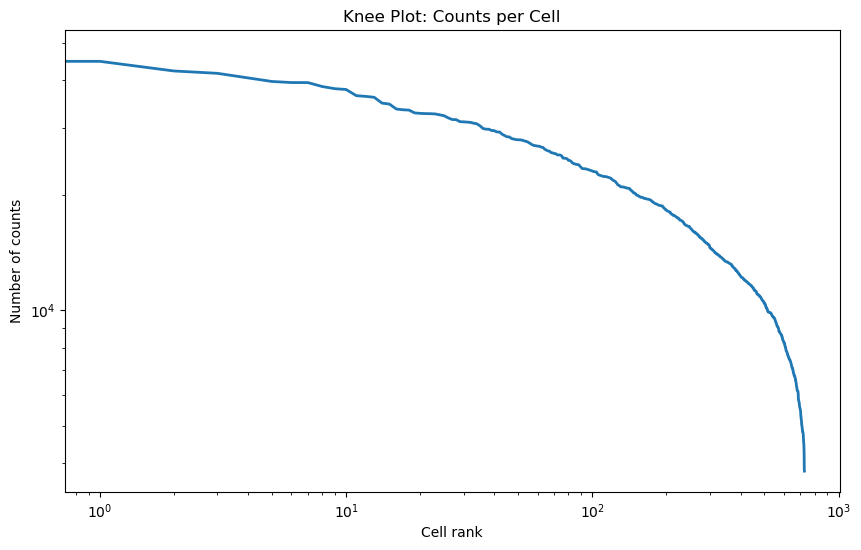

In [8]:
# Calculate number of genes per cell
sc.pp.calculate_qc_metrics(gaba_adata, inplace=True)

# Sort cells by number of genes
total_counts = np.sort(gaba_adata.obs.total_counts)[::-1]

# Create range for x-axis
cell_range = range(len(total_counts))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(cell_range, total_counts, linewidth=2)

plt.xlabel('Cell rank')
plt.ylabel('Number of counts')
plt.title('Knee Plot: Counts per Cell')

# Add log scales
plt.xscale('log')
plt.yscale('log')

plt.show()

Filter by number of counts if desired.

In [9]:
threshold = 10
sc.pp.filter_cells(gaba_adata, min_counts=threshold)
sc.pp.filter_cells(glu_adata, min_counts=threshold)

## Set up model and perform inference.

Optional Fit Parameters

In [10]:
transcriptome_filepath =  './monod_examples/polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
demo_genes = ['Eif5b','Xrcc5','Klhl12','Rgs7','Thsd7b']
lb, ub, samp_lb, samp_ub, gridsize = None, None, None, None, None # Can add as keywords if desired.

The expected modalities for this model are: ['unspliced', 'spliced']
If your anndata layers have different names, please give a modality dictionary of the form: modality_name_dict  = {'spliced':your_spliced_layer_name, 'unspliced':your_unspliced_layer_name} 
INFO:root:No dataset name given (dataset_string=None). Saving as Bursty_Poisson
INFO:root:Directory Bursty_Poisson already exists.
INFO:root:Beginning data extraction.
INFO:root:Dataset: Bursty_Poisson
INFO:root:Using default gene filtering parameters
is sparse
INFO:root:Added lengths
INFO:root:728 cells detected.
INFO:root:32005 genes detected.
4990 genes retained after expression filter.
INFO:root:Number of enforced genes: 5
INFO:root:0 random genes selected.
INFO:root:Total of 5 genes selected.
INFO:root:Data extracted
INFO:root:Search data created.
INFO:root:Directory Bursty_Poisson/Bursty_Poisson_6x7 already exists.
INFO:root:Global inference parameters stored to Bursty_Poisson/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Globa

100%|██████████| 42/42 [00:08<00:00,  5.02it/s]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory Bursty_Poisson/Bursty_Poisson_6x7/analysis_figures already exists.
INFO:root:Grid scan results stored to Bursty_Poisson/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:Runtime: 10.5 seconds.
INFO:root:Grid points fit.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters saved to anndata, under .var attributes in the form: "$\gamma$". Note that the parameters are given in log-base 10.
INFO:root:AIC values calculated and saved under .var attribute: AIC.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 0.9 seconds.
INFO:root:Uncertainties per gene calculated, saved to anndata in .var attribute of the form: "error_$\gamma$". Note that the errors are given for log-base 10 parameters.
INFO:root:Grid sc

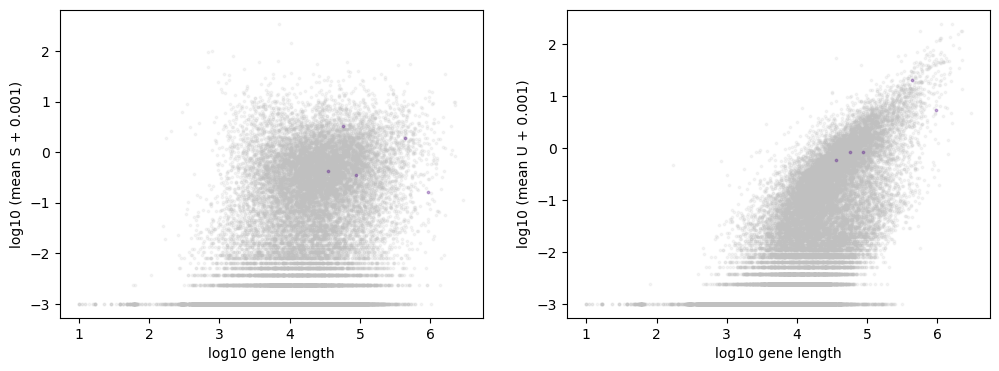

In [11]:
# Define model.
fitmodel = cme_toolbox.CMEModel('Bursty','Poisson')

# Define number of clusters and epochs if using meK-Means, otherwise set to None.
mek_means_params = None # (4,2)

gaba_adata = inference.perform_inference(gaba_adata, fitmodel, genes_to_fit=demo_genes,
                                         transcriptome_filepath=transcriptome_filepath,
                                         num_cores=16, mek_means_params=mek_means_params, n_genes=2,
                                         exclude_sigma = False)

INFO:root:Directory glu_example already exists.
INFO:root:Beginning data extraction.
INFO:root:Dataset: glu_example
INFO:root:Using default gene filtering parameters
INFO:root:Duplicate variable names found. Making them unique...
is sparse
INFO:root:Added lengths


/Users/ConradOakes/Library/r-miniconda/envs/monod/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


INFO:root:6629 cells detected.
INFO:root:31966 genes detected.
7294 genes retained after expression filter.
INFO:root:Number of enforced genes: 5
INFO:root:0 random genes selected.
INFO:root:Total of 5 genes selected.


/Users/ConradOakes/monod/./src/monod/extract_data.py:984: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  gene_exp_filter[gene_loc[0]] = False  # Exclude from sampling pool


INFO:root:Data extracted
INFO:root:Search data created.
INFO:root:Directory glu_example/Bursty_Poisson_6x7 already exists.
INFO:root:Global inference parameters stored to glu_example/Bursty_Poisson_6x7/parameters.pr.
INFO:root:Global inference parameters set.
INFO:root:Starting parallelized grid scan.


100%|██████████| 42/42 [00:09<00:00,  4.28it/s]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory glu_example/Bursty_Poisson_6x7/analysis_figures already exists.
INFO:root:Grid scan results stored to glu_example/Bursty_Poisson_6x7/grid_scan_results.res.
INFO:root:Runtime: 12.2 seconds.
INFO:root:Grid points fit.
INFO:root:Optimal parameters found.
INFO:root:Optimal parameters saved to anndata, under .var attributes in the form: "$\gamma$". Note that the parameters are given in log-base 10.
INFO:root:AIC values calculated and saved under .var attribute: AIC.
INFO:root:Computing local Hessian.
INFO:root:Starting non-parallelized Hessian computation.
INFO:root:Non-parallelized Hessian computation complete.
INFO:root:Standard error of the MLE computation complete. Runtime: 0.9 seconds.
INFO:root:Uncertainties per gene calculated, saved to anndata in .var attribute of the form: "error_$\gamma$". Note that the errors are given for log-base 10 parameters.
INFO:root:Grid scan res

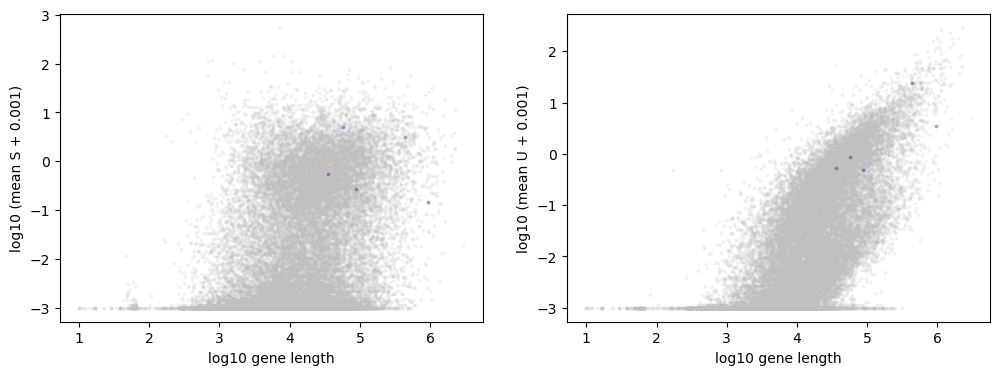

In [12]:
# Fix the genes to be the same as for the gaba data.
genes_to_fit = [i for i in gaba_adata.var_names]
n_genes = len(genes_to_fit)

glu_adata = inference.perform_inference('./glu_example.h5ad', fitmodel, n_genes=n_genes, genes_to_fit=genes_to_fit,
                transcriptome_filepath=transcriptome_filepath, mek_means_params=mek_means_params, num_cores=16,
                                         exclude_sigma = False)

## Access gene info.

In [13]:
# AIC.
display(gaba_adata.var[['AIC']])

# Optimum biological parameters and associated errors.
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if '$' in i]])

,AIC
gene_name,
Eif5b,5079.554315
Xrcc5,2911.339434
Klhl12,2846.619219
Rgs7,8387.555998
Thsd7b,4408.201034


,$b$,$\beta$,$\gamma$,error_$b$,error_$\beta$,error_$\gamma$
gene_name,,,,,,
Eif5b,1.766454,-0.175686,-0.248867,0.042352,0.041512,0.041999
Xrcc5,2.082072,0.290550,1.030607,0.050147,0.041281,0.052989
Klhl12,2.052352,0.030792,0.915332,0.057468,0.051751,0.060354
Rgs7,2.480994,0.014937,0.712543,0.029204,0.024961,0.029286
Thsd7b,1.880694,0.357837,1.294853,0.033945,0.026126,0.054289


In [14]:
# AIC.
display(glu_adata.var[['AIC']])

# Optimum biological parameters and associated errors.
display(glu_adata.var[[i for i in glu_adata.var.keys() if '$' in i]])

,AIC
gene_name,
Eif5b,50339.043825
Xrcc5,21206.130546
Klhl12,26447.489251
Rgs7,81311.696995
Thsd7b,33827.268230


,$b$,$\beta$,$\gamma$,error_$b$,error_$\beta$,error_$\gamma$
gene_name,,,,,,
Eif5b,1.684012,-0.277193,-0.523444,0.014181,0.014225,0.014115
Xrcc5,1.655983,0.127651,0.732127,0.020995,0.019267,0.022763
Klhl12,1.836976,-0.126966,0.588231,0.021149,0.019685,0.021745
Rgs7,2.230788,-0.315222,0.225164,0.008808,0.008006,0.008951
Thsd7b,1.808920,0.435358,1.147444,0.013479,0.009602,0.017837


## Plot parameter distributions.

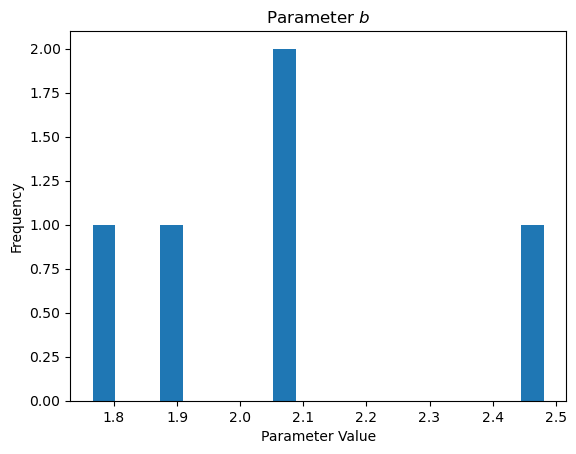

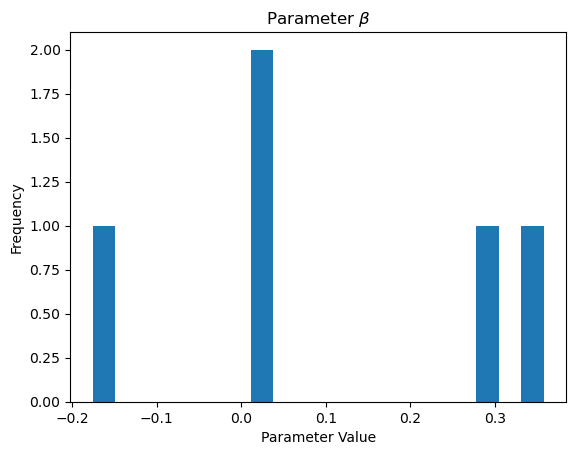

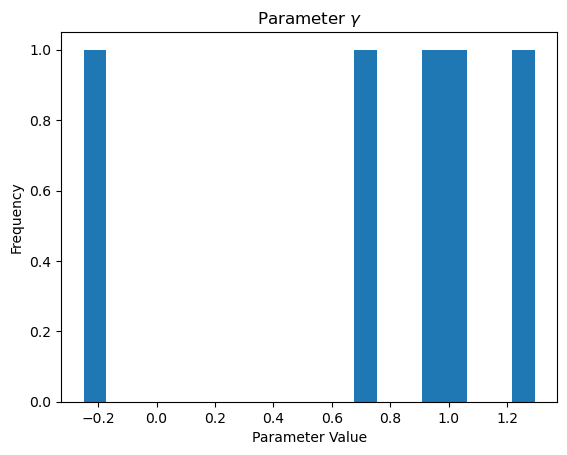

In [15]:
param_names = [i for i in gaba_adata.var.keys() if '$' in i and 'error' not in i]
for name in param_names:
    plt.hist(gaba_adata.var[name], bins=20)
    plt.title('Parameter ' + name)
    plt.xlabel('Parameter Value')
    plt.ylabel('Frequency')
    # plt.savefig(search_result.inference_string + '/parameter_dist_'+ str(i))#'/parameter_dist_{}'.format(
    plt.show()

# Analysis

## Reject genes.

In [16]:
# # Add rejection filter to adata.
gaba_adata = inference.reject_genes(gaba_adata, reject_at_bounds=False, mek_means=mek_means_params, save_csq=True)#, threshold=-1, use_hellinger=False, reject_at_bounds=False)
glu_adata = inference.reject_genes(glu_adata, reject_at_bounds=False, mek_means=mek_means_params, save_csq=True)#, threshold=-1, use_hellinger=False, reject_at_bounds=False)

# Show rejected genes.
display(glu_adata.var[[i for i in glu_adata.var.keys() if 'rejected' in i]])
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'rejected' in i]])

# Show chi-squared values, and other rejection statistics if saved.
display(glu_adata.var[[i for i in glu_adata.var.keys() if 'csq' in i or 'pval' in i or 'hellinger' in i]])
display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'csq' in i or 'pval' in i or 'hellinger' in i]])

# # # Save chi-square values.
# chi_squareds_glu,  chi_squareds_gaba = glu_adata.var['csq'], gaba_adata.var['csq']

INFO:root:P-value threshold: 0.05, Adjusted P-value threshold:0.05, Hellinger Threshold:0.05


INFO:root:Chi-square computation complete. Rejected 2 genes out of 5. Runtime: 0.0 seconds.
INFO:root:Chi-squared values for each gene have been added as "csq" in .var
INFO:root:P-values for each gene have been added as "pval" in .var
INFO:root:Hellinger distances for each gene have been added as "hellinger" in .var
INFO:root:Rejected genes are recorded in "rejected_genes" in .var
INFO:root:P-value threshold: 0.05, Adjusted P-value threshold:0.05, Hellinger Threshold:0.05
INFO:root:Chi-square computation complete. Rejected 1 genes out of 5. Runtime: 0.0 seconds.
INFO:root:Chi-squared values for each gene have been added as "csq" in .var
INFO:root:P-values for each gene have been added as "pval" in .var
INFO:root:Hellinger distances for each gene have been added as "hellinger" in .var
INFO:root:Rejected genes are recorded in "rejected_genes" in .var


,rejected_genes
gene_name,
Eif5b,False
Xrcc5,False
Klhl12,False
Rgs7,True
Thsd7b,False


,rejected_genes
gene_name,
Eif5b,False
Xrcc5,False
Klhl12,False
Rgs7,True
Thsd7b,True


,csq,pval,hellinger
gene_name,,,
Eif5b,162.335163,2.194356e-07,0.008358
Xrcc5,213.878688,1.223117e-36,0.008515
Klhl12,272.899565,2.660739e-46,0.011066
Rgs7,1043.061766,3.287691e-61,0.062887
Thsd7b,544.373634,1.458060e-74,0.019087


,csq,pval,hellinger
gene_name,,,
Eif5b,67.449844,2.489621e-04,0.035496
Xrcc5,32.454051,2.056533e-03,0.028863
Klhl12,50.979509,1.761699e-07,0.026517
Rgs7,317.415074,1.308344e-35,0.248241
Thsd7b,70.646677,3.511712e-08,0.071745


In [17]:
#dir(glu_adata.uns['search_result'])

## Execute differential expression analysis.

Fold changes saved to each dataframe under .var, e.g. FC_$\gamma$
Adjusted parameter values (subtracting the average fold change) saved to the second dataframe under .var, e.g. adj_$\gamma$
Adjusted fold changes (subtracting the average fold change) saved to each dataframe under .var, e.g. adj_FC_$\gamma$


/Users/ConradOakes/Library/r-miniconda/envs/monod/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


,FC_$b$,adj_FC_$b$,FC_$\beta$,adj_FC_$\beta$,FC_$\gamma$,adj_FC_$\gamma$
gene_name,,,,,,
Eif5b,0.082442,-0.174665,0.101507,-0.042342,0.274577,-0.028729
Xrcc5,0.426089,0.168982,0.162899,0.019050,0.298479,-0.004827
Klhl12,0.215377,-0.041730,0.157758,0.013909,0.327101,0.023795
Rgs7,NaN,NaN,NaN,NaN,NaN,NaN
Thsd7b,NaN,NaN,NaN,NaN,NaN,NaN


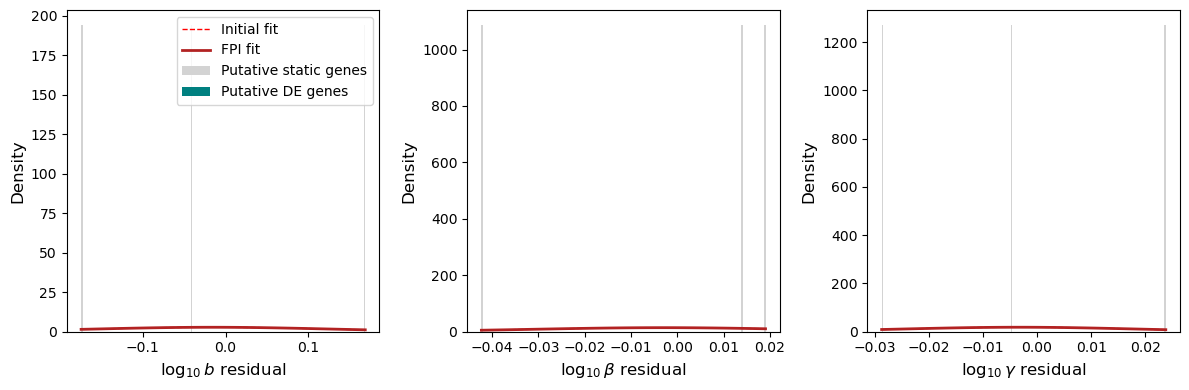

In [18]:
# If 2 anndata objects are given, parameters are compared across datasets.
if not mek_means_params:
    DE_genes, DE_filter, offs, residuals = analysis.DE_parameters(glu_adata, gaba_adata,
                                                              viz=True, use_sigma=True)

# If using meK-Means, compare clusters within one dataset.
else:
    DE_genes_gaba, DE_filter_gaba, offs_gaba, residuals_gaba = analysis.DE_parameters(gaba_adata,
                                                              viz=True, use_sigma=True, discard_rejected=True,
                                                                                     save_cluster_FCs=False)
    clusters = [i for i in DE_genes_gaba.keys()]
    DE_genes = [DE_genes_gaba[i] for i in clusters]
    param_names = gaba_adata.uns['search_result_list'][0].model.get_log_name_str()
    param_num, cluster_num = 0,0
    display(Markdown('E.g.' + param_names[param_num]))
    print(clusters[cluster_num], DE_genes[cluster_num][param_num])

display(gaba_adata.var[[i for i in gaba_adata.var.keys() if 'FC' in i]])

### Show some gene distributions.

[0 1 2]
Eif5b
Xrcc5
Klhl12


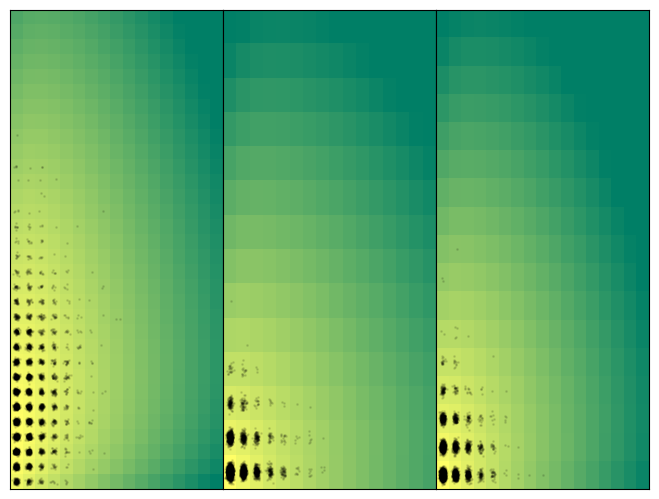

In [19]:
fitted_adata = glu_adata

search_result, search_data = fitted_adata.uns['search_result'], fitted_adata.uns['search_data']
logscale = True

sz =(1,3)
(nrows, ncols) = sz
fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols)

nax = np.prod(sz)

genes_to_plot = np.arange(nax)

genes_to_plot = np.asarray(genes_to_plot)
if genes_to_plot.dtype == bool:
    gtp_temp = np.arange(self.n_genes)
    genes_to_plot = gtp_temp[genes_to_plot]

number_of_genes_to_plot = len(genes_to_plot)
if number_of_genes_to_plot > 5:
    number_of_genes_to_plot = 5
    genes_to_plot = genes_to_plot[: 5]
if number_of_genes_to_plot > nax:  # This should no longer break...
    number_of_genes_to_plot = nax
    genes_to_plot = genes_to_plot[:nax]

j_ = 0
marg = 'joint'
modalities = ['spliced', 'unspliced']

print(genes_to_plot)
for i_ in genes_to_plot:
    lm = np.copy(search_data.M[:, i_])

    # TODO: generalize by adding attribute names as attribute of e.g. CMEModel
    # attributes = ['unspliced', 'spliced', 'protein']

    num_modalities = 2
    for i in range(num_modalities):
        if marg == modalities[i]:
            lm[:i] = 1
            lm[i+1:]=1

    axloc = np.unravel_index(j_, sz) if (sz[0] > 1 and sz[1] > 1) else j_

    samp = search_result.regressor_optimum[i_]
    Pa = np.squeeze(search_result.model.eval_model_pss(search_result.phys_optimum[i_], lm, samp))
    layers = np.array([i.copy() for i in search_data.layers])

    marg = 'joint'
    if marg == "joint":
        if logscale:
            Pa[Pa < 1e-10] = 1e-10
            Pa = np.log10(Pa)

        if num_modalities==2:
            ax1[axloc].imshow(Pa.T, aspect="auto", cmap="summer")
        elif num_modalities==3:
            ax1[axloc].imshow(Pa.sum(axis=2).T, aspect="auto", cmap="summer")
        else:
            log.error('Joint distribution plot only implemented for 2 or 3 modalities')

        ax1[axloc].invert_yaxis()

        jitter_magn = 0.1
        jitter = np.random.randn(2, search_result.n_cells) * jitter_magn
        ax1[axloc].scatter(
            *layers[:2, :,i_] + jitter, c="k", s=1, alpha=0.1
        )

        ax1[axloc].set_xlim([-0.5, search_data.M[0, i_] - 1.5])
        ax1[axloc].set_ylim([-0.5, search_data.M[1, i_] - 1.5])
    else:
        plot_hist_and_fit(ax1[axloc], search_data, i_, Pa, marg)
        if logscale:
            ax1[axloc].set_yscale("log")

    print(search_result.gene_names[i_])
    # if title:
    #     titlestr = search_result.gene_names[i_]
    #     if hasattr(search_result, "rejected_genes") and search_result.rejected_genes[i_]:
    #         titlestr += " (rej.)"
    #     ax1[axloc].set_title(titlestr, fontdict={"fontsize": 9})
    ax1[axloc].set_xticks([])
    ax1[axloc].set_yticks([])
    j_ += 1
fig1.tight_layout(pad=0.02)


INFO:root:Figure stored to Bursty_Poisson/Bursty_Poisson_6x7/analysis_figures/kldiv.png.
INFO:root:Figure stored to Bursty_Poisson/Bursty_Poisson_6x7/analysis_figures/gene_distributions_joint.png.


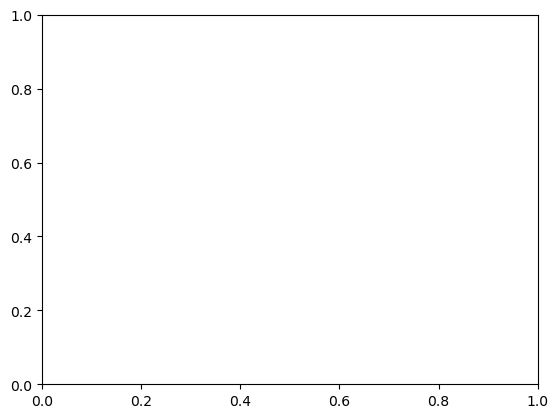

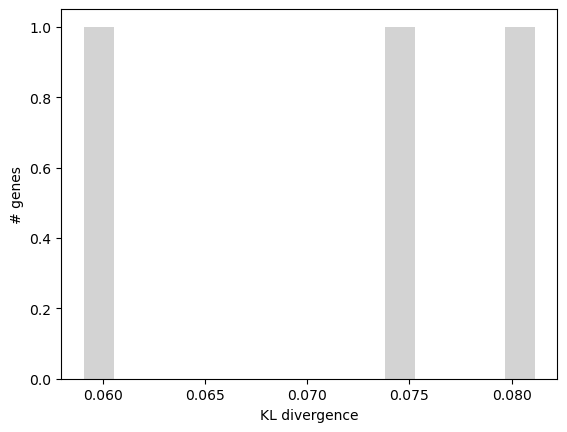

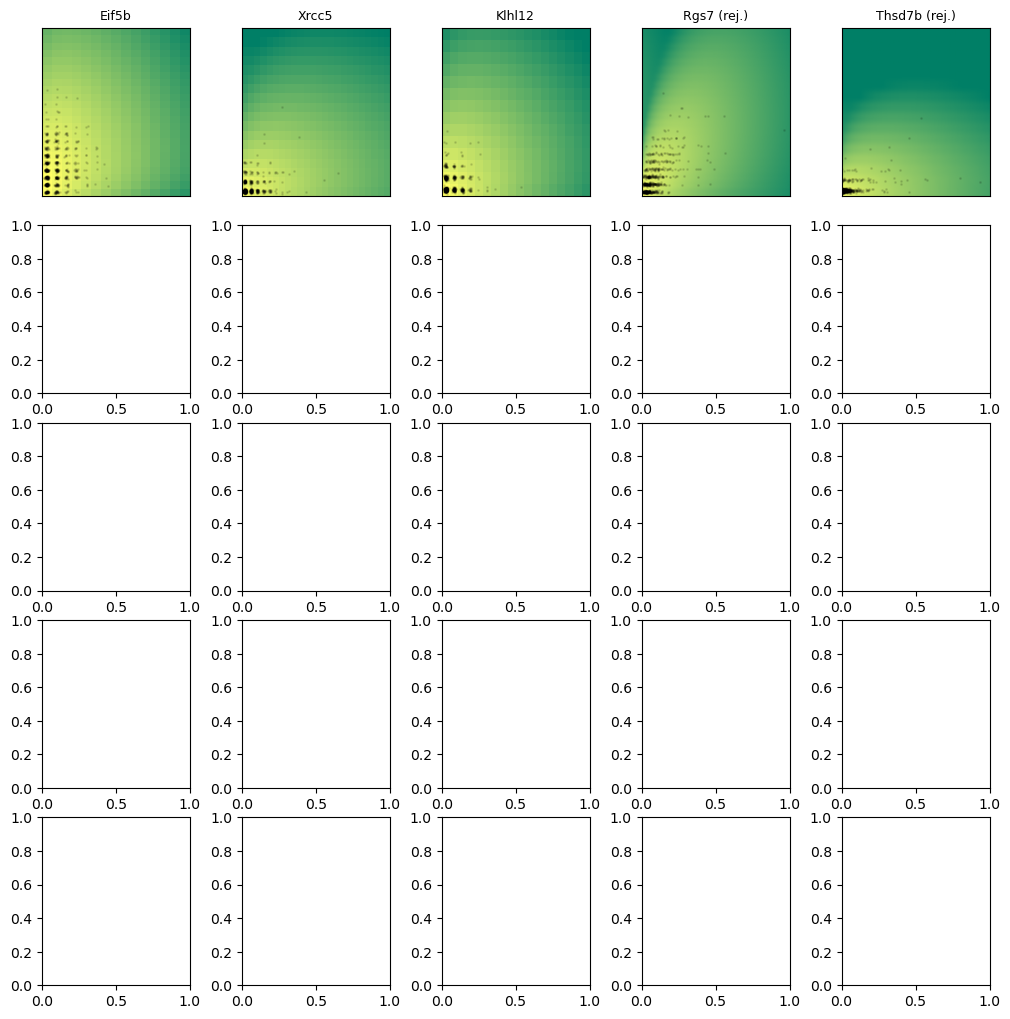

In [20]:
analysis.run_qc(gaba_adata)